### 6. Нейросети в обработке текста<br>
Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech<dr>
Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [5]:
!pip install stop-words

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=824c3c9f75c525ea6057ec5d39e69f0391313ff1126645ff77125d31dab51c5e
  Stored in directory: c:\users\инна\appdata\local\pip\cache\wheels\da\d8\66\395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop-words


In [6]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


%matplotlib inline

Загрузим данные и посмотрим на них

In [3]:
df_train = pd.read_csv('train (6).csv')
df_test = pd.read_csv('test (6).csv')
df_val = pd.read_csv('val (6).csv')

In [4]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [7]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [8]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
1,181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


Зададим ряд гиперпараметров, которые будут использоваться в дальнейшем процессе обучения.

In [9]:
max_words = 1500
max_len = 15
num_classes = 1

# Training
epochs = 7
batch_size = 512
embedding_dim = 256
out_channel = 256

Предобработка

In [10]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [11]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [12]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Инна\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [13]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [14]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [15]:
tokens_filtered_top[10:]

vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [16]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [17]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [18]:
x_train.shape
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 213, 448,
       170,   9])

Инициализируем устройство, на котором будем обучать модель

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


Инициализируем и обучим сеть на данных

In [21]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [22]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
model = Net(vocab_size=max_words)

print(model)
print("Параметры:", sum([param.nelement() for param in model.parameters()]))

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Эпохи обучения {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        
        output = model(data)
        
        # вычислить градиент и выполнить шаг SGD
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
       # if i%print_batch_n == 0:
        loss = loss.float().item()
        print("Шаг {}: loss={}".format(i, loss))
        loss_history.append(loss)

Net(
  (embedding): Embedding(1500, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Параметры: 241409
Эпохи обучения 1/7
Шаг 0: loss=0.7011668086051941
Шаг 1: loss=2.4043142795562744
Шаг 2: loss=0.7980731725692749
Шаг 3: loss=0.9029861092567444
Шаг 4: loss=0.8230916261672974
Шаг 5: loss=0.722658097743988
Шаг 6: loss=0.6902914047241211
Шаг 7: loss=0.6720389723777771
Шаг 8: loss=0.6400778293609619
Шаг 9: loss=0.662818968296051
Шаг 10: loss=0.6545016169548035
Шаг 11: loss=0.7150373458862305
Шаг 12: loss=0.7236680388450623
Шаг 13: loss=0.6904301047325134
Шаг 14: loss=0.6505577564239502
Шаг 15: loss=0.6379381418228149
Шаг 16: loss=0.64528888463974
Шаг 17: loss=0.6580896377563477
Шаг 18: loss=0.6673195362091064
Шаг 19: loss=0.6636064648628235
Шаг 20: loss=0.6745187640190125
Шаг 21: loss=0.6543012261390686
Шаг 22: loss=0.6566793918609619
Шаг 23: loss=0.6429766416549683
Шаг 24: loss=0.6426649689674

Шаг 246: loss=0.5861148238182068
Шаг 247: loss=0.5419053435325623
Шаг 248: loss=0.56297367811203
Шаг 249: loss=0.6054856181144714
Шаг 250: loss=0.5740737318992615
Шаг 251: loss=0.5601872801780701
Шаг 252: loss=0.546173632144928
Шаг 253: loss=0.563775897026062
Шаг 254: loss=0.5671605467796326
Шаг 255: loss=0.5512129664421082
Шаг 256: loss=0.5759530067443848
Шаг 257: loss=0.5717347860336304
Шаг 258: loss=0.5331721305847168
Шаг 259: loss=0.5610581636428833
Шаг 260: loss=0.5598474144935608
Шаг 261: loss=0.5683194994926453
Шаг 262: loss=0.5296313166618347
Шаг 263: loss=0.5687330365180969
Шаг 264: loss=0.5398967266082764
Шаг 265: loss=0.5483303666114807
Шаг 266: loss=0.56852787733078
Шаг 267: loss=0.5654942393302917
Шаг 268: loss=0.5773550868034363
Шаг 269: loss=0.5818748474121094
Шаг 270: loss=0.5490761995315552
Шаг 271: loss=0.5783959627151489
Шаг 272: loss=0.5826427936553955
Шаг 273: loss=0.5696917176246643
Шаг 274: loss=0.5574654936790466
Шаг 275: loss=0.5462502241134644
Шаг 276: loss=0.

Шаг 146: loss=0.5715264678001404
Шаг 147: loss=0.5464587211608887
Шаг 148: loss=0.5606485605239868
Шаг 149: loss=0.5534008145332336
Шаг 150: loss=0.5584094524383545
Шаг 151: loss=0.5547918081283569
Шаг 152: loss=0.5456774234771729
Шаг 153: loss=0.5869981050491333
Шаг 154: loss=0.5708828568458557
Шаг 155: loss=0.5561494827270508
Шаг 156: loss=0.5642173886299133
Шаг 157: loss=0.5317462086677551
Шаг 158: loss=0.5324550271034241
Шаг 159: loss=0.4958380460739136
Шаг 160: loss=0.583942174911499
Шаг 161: loss=0.5814659595489502
Шаг 162: loss=0.5326719284057617
Шаг 163: loss=0.5880515575408936
Шаг 164: loss=0.5575276613235474
Шаг 165: loss=0.5832834839820862
Шаг 166: loss=0.5458430051803589
Шаг 167: loss=0.5778355598449707
Шаг 168: loss=0.5441649556159973
Шаг 169: loss=0.5339864492416382
Шаг 170: loss=0.5501165390014648
Шаг 171: loss=0.551131010055542
Шаг 172: loss=0.5267825722694397
Шаг 173: loss=0.5912399888038635
Шаг 174: loss=0.5719037652015686
Шаг 175: loss=0.5381873846054077
Шаг 176: los

Шаг 43: loss=0.5154777765274048
Шаг 44: loss=0.46556150913238525
Шаг 45: loss=0.5223793983459473
Шаг 46: loss=0.5784305334091187
Шаг 47: loss=0.5130001306533813
Шаг 48: loss=0.5345994234085083
Шаг 49: loss=0.5135308504104614
Шаг 50: loss=0.4963868260383606
Шаг 51: loss=0.5633295178413391
Шаг 52: loss=0.5573397874832153
Шаг 53: loss=0.5033712387084961
Шаг 54: loss=0.5272404551506042
Шаг 55: loss=0.49708276987075806
Шаг 56: loss=0.5591400265693665
Шаг 57: loss=0.5078121423721313
Шаг 58: loss=0.5358625054359436
Шаг 59: loss=0.5306993126869202
Шаг 60: loss=0.5171518325805664
Шаг 61: loss=0.5314236283302307
Шаг 62: loss=0.5164533853530884
Шаг 63: loss=0.5032150745391846
Шаг 64: loss=0.5268943905830383
Шаг 65: loss=0.541118860244751
Шаг 66: loss=0.5456148982048035
Шаг 67: loss=0.497997909784317
Шаг 68: loss=0.5436562895774841
Шаг 69: loss=0.5106104612350464
Шаг 70: loss=0.5085700154304504
Шаг 71: loss=0.5261769890785217
Шаг 72: loss=0.5067175626754761
Шаг 73: loss=0.49597227573394775
Шаг 74:

Шаг 296: loss=0.5086429119110107
Шаг 297: loss=0.5296686291694641
Шаг 298: loss=0.5264150500297546
Шаг 299: loss=0.5652603507041931
Шаг 300: loss=0.49632927775382996
Шаг 301: loss=0.5386529564857483
Шаг 302: loss=0.5598184466362
Шаг 303: loss=0.5247742533683777
Шаг 304: loss=0.5442643165588379
Шаг 305: loss=0.5414770245552063
Шаг 306: loss=0.5240771174430847
Шаг 307: loss=0.5283840894699097
Шаг 308: loss=0.5193506479263306
Шаг 309: loss=0.5579341650009155
Шаг 310: loss=0.48398497700691223
Шаг 311: loss=0.5482263565063477
Шаг 312: loss=0.5252701640129089
Шаг 313: loss=0.5381900668144226
Шаг 314: loss=0.49761953949928284
Шаг 315: loss=0.5069729685783386
Шаг 316: loss=0.5180882215499878
Шаг 317: loss=0.5844252705574036
Шаг 318: loss=0.5761752724647522
Шаг 319: loss=0.5096471309661865
Шаг 320: loss=0.5266322493553162
Шаг 321: loss=0.5387011766433716
Шаг 322: loss=0.5165618658065796
Шаг 323: loss=0.5365002751350403
Шаг 324: loss=0.547989547252655
Шаг 325: loss=0.5306596755981445
Шаг 326: lo

Шаг 192: loss=0.5066264867782593
Шаг 193: loss=0.5372346043586731
Шаг 194: loss=0.48485875129699707
Шаг 195: loss=0.5125054121017456
Шаг 196: loss=0.5121681690216064
Шаг 197: loss=0.5274358987808228
Шаг 198: loss=0.4924572706222534
Шаг 199: loss=0.5297651290893555
Шаг 200: loss=0.5538512468338013
Шаг 201: loss=0.553321123123169
Шаг 202: loss=0.4990350604057312
Шаг 203: loss=0.5033048391342163
Шаг 204: loss=0.5131509304046631
Шаг 205: loss=0.5044913291931152
Шаг 206: loss=0.5337740778923035
Шаг 207: loss=0.5158460736274719
Шаг 208: loss=0.48610907793045044
Шаг 209: loss=0.49140220880508423
Шаг 210: loss=0.5029370188713074
Шаг 211: loss=0.5028475522994995
Шаг 212: loss=0.5082441568374634
Шаг 213: loss=0.4780353903770447
Шаг 214: loss=0.4857192039489746
Шаг 215: loss=0.5707569718360901
Шаг 216: loss=0.49870744347572327
Шаг 217: loss=0.48127028346061707
Шаг 218: loss=0.5024999380111694
Шаг 219: loss=0.47668352723121643
Шаг 220: loss=0.4973970353603363
Шаг 221: loss=0.4945189654827118
Шаг 2

Шаг 89: loss=0.49075406789779663
Шаг 90: loss=0.4922102391719818
Шаг 91: loss=0.459711492061615
Шаг 92: loss=0.4405580461025238
Шаг 93: loss=0.47777441143989563
Шаг 94: loss=0.4927706718444824
Шаг 95: loss=0.45446887612342834
Шаг 96: loss=0.4699386954307556
Шаг 97: loss=0.4825628995895386
Шаг 98: loss=0.5015119314193726
Шаг 99: loss=0.4780064821243286
Шаг 100: loss=0.4538974463939667
Шаг 101: loss=0.47478604316711426
Шаг 102: loss=0.497945100069046
Шаг 103: loss=0.5099364519119263
Шаг 104: loss=0.46992453932762146
Шаг 105: loss=0.47586214542388916
Шаг 106: loss=0.48271486163139343
Шаг 107: loss=0.45894667506217957
Шаг 108: loss=0.4922844171524048
Шаг 109: loss=0.5281984210014343
Шаг 110: loss=0.48298853635787964
Шаг 111: loss=0.46753358840942383
Шаг 112: loss=0.45179930329322815
Шаг 113: loss=0.460502028465271
Шаг 114: loss=0.4742305874824524
Шаг 115: loss=0.4779016375541687
Шаг 116: loss=0.4847009778022766
Шаг 117: loss=0.43418025970458984
Шаг 118: loss=0.47591161727905273
Шаг 119: lo

Шаг 336: loss=0.47124359011650085
Шаг 337: loss=0.5156400799751282
Шаг 338: loss=0.47583773732185364
Шаг 339: loss=0.50129234790802
Шаг 340: loss=0.4865351915359497
Шаг 341: loss=0.5134731531143188
Шаг 342: loss=0.47755128145217896
Шаг 343: loss=0.46834203600883484
Шаг 344: loss=0.5084548592567444
Шаг 345: loss=0.5062845349311829
Шаг 346: loss=0.5316289067268372
Шаг 347: loss=0.484483927488327
Шаг 348: loss=0.4740101993083954
Шаг 349: loss=0.49741584062576294
Шаг 350: loss=0.4367823898792267
Шаг 351: loss=0.5318737030029297
Шаг 352: loss=0.5120096802711487
Шаг 353: loss=0.5408843755722046
Шаг 354: loss=0.5139909386634827
Эпохи обучения 6/7
Шаг 0: loss=0.4028595983982086
Шаг 1: loss=0.4364396333694458
Шаг 2: loss=0.42556390166282654
Шаг 3: loss=0.43098586797714233
Шаг 4: loss=0.41405922174453735
Шаг 5: loss=0.4157831072807312
Шаг 6: loss=0.40915730595588684
Шаг 7: loss=0.44257214665412903
Шаг 8: loss=0.45074373483657837
Шаг 9: loss=0.3968784809112549
Шаг 10: loss=0.4289535880088806
Шаг 

Шаг 232: loss=0.45343756675720215
Шаг 233: loss=0.4790927767753601
Шаг 234: loss=0.47048017382621765
Шаг 235: loss=0.46788859367370605
Шаг 236: loss=0.49721822142601013
Шаг 237: loss=0.4938734471797943
Шаг 238: loss=0.4332258105278015
Шаг 239: loss=0.44339850544929504
Шаг 240: loss=0.4551839232444763
Шаг 241: loss=0.4498971104621887
Шаг 242: loss=0.47825881838798523
Шаг 243: loss=0.45648083090782166
Шаг 244: loss=0.43422797322273254
Шаг 245: loss=0.44301703572273254
Шаг 246: loss=0.45466524362564087
Шаг 247: loss=0.456149160861969
Шаг 248: loss=0.45591098070144653
Шаг 249: loss=0.46295833587646484
Шаг 250: loss=0.4230644702911377
Шаг 251: loss=0.45768094062805176
Шаг 252: loss=0.4537128508090973
Шаг 253: loss=0.48950091004371643
Шаг 254: loss=0.5158967971801758
Шаг 255: loss=0.4853607416152954
Шаг 256: loss=0.4601191580295563
Шаг 257: loss=0.4135691225528717
Шаг 258: loss=0.4266967475414276
Шаг 259: loss=0.49867725372314453
Шаг 260: loss=0.5110676288604736
Шаг 261: loss=0.4653157591819

Шаг 127: loss=0.41679647564888
Шаг 128: loss=0.39381200075149536
Шаг 129: loss=0.41551315784454346
Шаг 130: loss=0.40449389815330505
Шаг 131: loss=0.4385493993759155
Шаг 132: loss=0.4235280752182007
Шаг 133: loss=0.4051426947116852
Шаг 134: loss=0.3672427237033844
Шаг 135: loss=0.451016902923584
Шаг 136: loss=0.41446250677108765
Шаг 137: loss=0.41636955738067627
Шаг 138: loss=0.41777902841567993
Шаг 139: loss=0.41791772842407227
Шаг 140: loss=0.3849828839302063
Шаг 141: loss=0.39252057671546936
Шаг 142: loss=0.41456320881843567
Шаг 143: loss=0.43659013509750366
Шаг 144: loss=0.44779396057128906
Шаг 145: loss=0.3899986147880554
Шаг 146: loss=0.41719701886177063
Шаг 147: loss=0.41540372371673584
Шаг 148: loss=0.38959598541259766
Шаг 149: loss=0.3882710933685303
Шаг 150: loss=0.39576393365859985
Шаг 151: loss=0.43936285376548767
Шаг 152: loss=0.4099096953868866
Шаг 153: loss=0.3902072608470917
Шаг 154: loss=0.39351996779441833
Шаг 155: loss=0.4712296724319458
Шаг 156: loss=0.4182343184947

Посмотрим на результаты

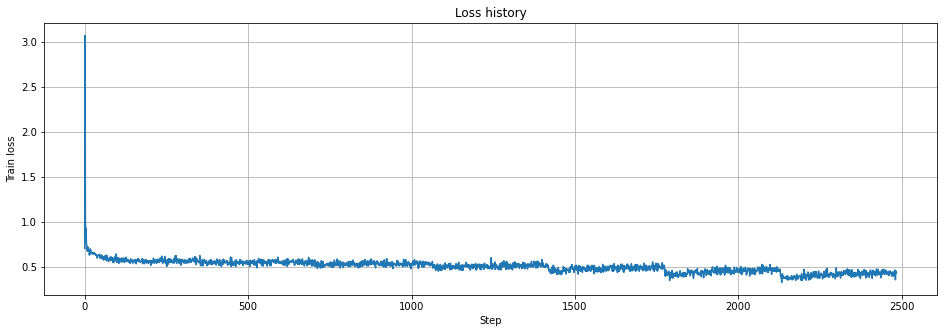

In [30]:
plt.figure(figsize = (16,5))
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

Проверим модель на тесте

In [26]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
model = Net(vocab_size=max_words)

print(model)
print("Параметры:", sum([param.nelement() for param in model.parameters()]))

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Эпохи обучения {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        
        output = model(data)
        
        # вычислить градиент и выполнить шаг SGD
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
       # if i%print_batch_n == 0:
        loss = loss.float().item()
        print("Шаг {}: loss={}".format(i, loss))
        loss_history.append(loss)

Net(
  (embedding): Embedding(1500, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Параметры: 241409
Эпохи обучения 1/7
Шаг 0: loss=0.7071921825408936
Шаг 1: loss=3.0749895572662354
Шаг 2: loss=0.7874826192855835
Шаг 3: loss=0.8850842118263245
Шаг 4: loss=0.9327740669250488
Шаг 5: loss=0.7673937082290649
Шаг 6: loss=0.741902232170105
Шаг 7: loss=0.6890381574630737
Шаг 8: loss=0.6754518747329712
Шаг 9: loss=0.7239888310432434
Шаг 10: loss=0.6744624972343445
Шаг 11: loss=0.7033106684684753
Шаг 12: loss=0.6985693573951721
Шаг 13: loss=0.6927175521850586
Шаг 14: loss=0.6304565072059631
Шаг 15: loss=0.6537219882011414
Шаг 16: loss=0.6395938992500305
Шаг 17: loss=0.6995036602020264
Шаг 18: loss=0.6749220490455627
Шаг 19: loss=0.6751303672790527
Шаг 20: loss=0.6567786335945129
Шаг 21: loss=0.6582382321357727
Шаг 22: loss=0.6473644971847534
Шаг 23: loss=0.6569924354553223
Шаг 24: loss=0.6425083875

Шаг 248: loss=0.5459846258163452
Шаг 249: loss=0.5331794023513794
Шаг 250: loss=0.5420147180557251
Шаг 251: loss=0.5044305324554443
Шаг 252: loss=0.5565658211708069
Шаг 253: loss=0.583555281162262
Шаг 254: loss=0.5694535374641418
Шаг 255: loss=0.5289114713668823
Шаг 256: loss=0.5540088415145874
Шаг 257: loss=0.5923731923103333
Шаг 258: loss=0.5497661828994751
Шаг 259: loss=0.5589106678962708
Шаг 260: loss=0.5478007793426514
Шаг 261: loss=0.5726246237754822
Шаг 262: loss=0.5881033539772034
Шаг 263: loss=0.548368513584137
Шаг 264: loss=0.562045693397522
Шаг 265: loss=0.5778226852416992
Шаг 266: loss=0.5697302222251892
Шаг 267: loss=0.5613434314727783
Шаг 268: loss=0.5562925338745117
Шаг 269: loss=0.5438857674598694
Шаг 270: loss=0.5532286167144775
Шаг 271: loss=0.5591289401054382
Шаг 272: loss=0.5892672538757324
Шаг 273: loss=0.5410497188568115
Шаг 274: loss=0.5790759325027466
Шаг 275: loss=0.555641770362854
Шаг 276: loss=0.564094603061676
Шаг 277: loss=0.6241015791893005
Шаг 278: loss=0

Шаг 146: loss=0.553706705570221
Шаг 147: loss=0.5636045336723328
Шаг 148: loss=0.5516285300254822
Шаг 149: loss=0.5601308345794678
Шаг 150: loss=0.5047146081924438
Шаг 151: loss=0.5626071691513062
Шаг 152: loss=0.573326587677002
Шаг 153: loss=0.53937828540802
Шаг 154: loss=0.543134331703186
Шаг 155: loss=0.5439638495445251
Шаг 156: loss=0.5640318989753723
Шаг 157: loss=0.5414137244224548
Шаг 158: loss=0.5532903075218201
Шаг 159: loss=0.5688492655754089
Шаг 160: loss=0.5335365533828735
Шаг 161: loss=0.5603805780410767
Шаг 162: loss=0.5196836590766907
Шаг 163: loss=0.5214717388153076
Шаг 164: loss=0.5806319117546082
Шаг 165: loss=0.5404794216156006
Шаг 166: loss=0.5480880737304688
Шаг 167: loss=0.547224223613739
Шаг 168: loss=0.5157232880592346
Шаг 169: loss=0.5525888204574585
Шаг 170: loss=0.5542306900024414
Шаг 171: loss=0.5639296770095825
Шаг 172: loss=0.48877376317977905
Шаг 173: loss=0.5552932024002075
Шаг 174: loss=0.5684944987297058
Шаг 175: loss=0.5443787574768066
Шаг 176: loss=0

Шаг 43: loss=0.5532863736152649
Шаг 44: loss=0.504609227180481
Шаг 45: loss=0.5390306711196899
Шаг 46: loss=0.4936656355857849
Шаг 47: loss=0.5498324632644653
Шаг 48: loss=0.5251114368438721
Шаг 49: loss=0.5291246175765991
Шаг 50: loss=0.540519118309021
Шаг 51: loss=0.49492770433425903
Шаг 52: loss=0.5492696166038513
Шаг 53: loss=0.5105159878730774
Шаг 54: loss=0.5758918523788452
Шаг 55: loss=0.5403754711151123
Шаг 56: loss=0.5269207954406738
Шаг 57: loss=0.5372035503387451
Шаг 58: loss=0.5167083740234375
Шаг 59: loss=0.5467074513435364
Шаг 60: loss=0.5206088423728943
Шаг 61: loss=0.5167966485023499
Шаг 62: loss=0.587005078792572
Шаг 63: loss=0.5173200368881226
Шаг 64: loss=0.5138256549835205
Шаг 65: loss=0.5685237646102905
Шаг 66: loss=0.5180175304412842
Шаг 67: loss=0.5121071338653564
Шаг 68: loss=0.5501075983047485
Шаг 69: loss=0.5525566339492798
Шаг 70: loss=0.5205056667327881
Шаг 71: loss=0.5660414099693298
Шаг 72: loss=0.4872315227985382
Шаг 73: loss=0.5233709216117859
Шаг 74: lo

Шаг 295: loss=0.5240815281867981
Шаг 296: loss=0.5189595222473145
Шаг 297: loss=0.5431767702102661
Шаг 298: loss=0.5237874984741211
Шаг 299: loss=0.5790681838989258
Шаг 300: loss=0.5204268097877502
Шаг 301: loss=0.5537937879562378
Шаг 302: loss=0.5258370041847229
Шаг 303: loss=0.5429670810699463
Шаг 304: loss=0.5441321730613708
Шаг 305: loss=0.566552996635437
Шаг 306: loss=0.536281943321228
Шаг 307: loss=0.5360962748527527
Шаг 308: loss=0.5563274621963501
Шаг 309: loss=0.5122791528701782
Шаг 310: loss=0.5536420345306396
Шаг 311: loss=0.4827560484409332
Шаг 312: loss=0.5406524538993835
Шаг 313: loss=0.4991576075553894
Шаг 314: loss=0.523298978805542
Шаг 315: loss=0.5346037149429321
Шаг 316: loss=0.5665507316589355
Шаг 317: loss=0.5486494302749634
Шаг 318: loss=0.5305918455123901
Шаг 319: loss=0.5435718894004822
Шаг 320: loss=0.5519199371337891
Шаг 321: loss=0.5368449687957764
Шаг 322: loss=0.4970819652080536
Шаг 323: loss=0.5318447947502136
Шаг 324: loss=0.5303313732147217
Шаг 325: loss

Шаг 192: loss=0.53046715259552
Шаг 193: loss=0.49408048391342163
Шаг 194: loss=0.5038354396820068
Шаг 195: loss=0.5227922797203064
Шаг 196: loss=0.5057774782180786
Шаг 197: loss=0.4942884147167206
Шаг 198: loss=0.4765658676624298
Шаг 199: loss=0.49098411202430725
Шаг 200: loss=0.5017414093017578
Шаг 201: loss=0.49492138624191284
Шаг 202: loss=0.5072959065437317
Шаг 203: loss=0.4666956961154938
Шаг 204: loss=0.4731716215610504
Шаг 205: loss=0.5336673855781555
Шаг 206: loss=0.5149378776550293
Шаг 207: loss=0.5241660475730896
Шаг 208: loss=0.5155013799667358
Шаг 209: loss=0.4661147892475128
Шаг 210: loss=0.5454638004302979
Шаг 211: loss=0.494122713804245
Шаг 212: loss=0.49865883588790894
Шаг 213: loss=0.5352950692176819
Шаг 214: loss=0.5445654392242432
Шаг 215: loss=0.5005277395248413
Шаг 216: loss=0.5587677955627441
Шаг 217: loss=0.5235201120376587
Шаг 218: loss=0.5675623416900635
Шаг 219: loss=0.5192148089408875
Шаг 220: loss=0.5276564359664917
Шаг 221: loss=0.5017324090003967
Шаг 222: 

Шаг 87: loss=0.50251704454422
Шаг 88: loss=0.45670294761657715
Шаг 89: loss=0.4363672137260437
Шаг 90: loss=0.4179799258708954
Шаг 91: loss=0.4831889271736145
Шаг 92: loss=0.5148364901542664
Шаг 93: loss=0.4983780086040497
Шаг 94: loss=0.47295019030570984
Шаг 95: loss=0.45922887325286865
Шаг 96: loss=0.5084065794944763
Шаг 97: loss=0.45045149326324463
Шаг 98: loss=0.48302796483039856
Шаг 99: loss=0.4871501922607422
Шаг 100: loss=0.4636231064796448
Шаг 101: loss=0.46807390451431274
Шаг 102: loss=0.4989433288574219
Шаг 103: loss=0.4390074908733368
Шаг 104: loss=0.49617305397987366
Шаг 105: loss=0.47146207094192505
Шаг 106: loss=0.4922148883342743
Шаг 107: loss=0.4986637234687805
Шаг 108: loss=0.4858800172805786
Шаг 109: loss=0.4919467866420746
Шаг 110: loss=0.4679444134235382
Шаг 111: loss=0.45758965611457825
Шаг 112: loss=0.45862260460853577
Шаг 113: loss=0.4554719626903534
Шаг 114: loss=0.48350030183792114
Шаг 115: loss=0.44733041524887085
Шаг 116: loss=0.472464919090271
Шаг 117: loss=

Шаг 335: loss=0.48125243186950684
Шаг 336: loss=0.48777133226394653
Шаг 337: loss=0.49722617864608765
Шаг 338: loss=0.5183614492416382
Шаг 339: loss=0.5059368014335632
Шаг 340: loss=0.4930991530418396
Шаг 341: loss=0.49747657775878906
Шаг 342: loss=0.48623746633529663
Шаг 343: loss=0.48426002264022827
Шаг 344: loss=0.4857121407985687
Шаг 345: loss=0.497713178396225
Шаг 346: loss=0.4748951196670532
Шаг 347: loss=0.5449167490005493
Шаг 348: loss=0.4789826571941376
Шаг 349: loss=0.4883350729942322
Шаг 350: loss=0.4792361855506897
Шаг 351: loss=0.5000997185707092
Шаг 352: loss=0.520596444606781
Шаг 353: loss=0.5079836845397949
Шаг 354: loss=0.5133168697357178
Эпохи обучения 6/7
Шаг 0: loss=0.4080648422241211
Шаг 1: loss=0.4474320709705353
Шаг 2: loss=0.3945767283439636
Шаг 3: loss=0.4452010989189148
Шаг 4: loss=0.4664008617401123
Шаг 5: loss=0.43392637372016907
Шаг 6: loss=0.4076133370399475
Шаг 7: loss=0.4058065414428711
Шаг 8: loss=0.4389929473400116
Шаг 9: loss=0.41231125593185425
Шаг 1

Шаг 229: loss=0.4440344572067261
Шаг 230: loss=0.4861443340778351
Шаг 231: loss=0.46546363830566406
Шаг 232: loss=0.424408495426178
Шаг 233: loss=0.5021845102310181
Шаг 234: loss=0.46700000762939453
Шаг 235: loss=0.43625375628471375
Шаг 236: loss=0.41611015796661377
Шаг 237: loss=0.44650962948799133
Шаг 238: loss=0.4334421455860138
Шаг 239: loss=0.46806570887565613
Шаг 240: loss=0.4822927415370941
Шаг 241: loss=0.45472145080566406
Шаг 242: loss=0.4850074052810669
Шаг 243: loss=0.46745508909225464
Шаг 244: loss=0.4736814498901367
Шаг 245: loss=0.4492320120334625
Шаг 246: loss=0.4717337191104889
Шаг 247: loss=0.495311439037323
Шаг 248: loss=0.4731992185115814
Шаг 249: loss=0.45146095752716064
Шаг 250: loss=0.40861302614212036
Шаг 251: loss=0.4415879547595978
Шаг 252: loss=0.43340790271759033
Шаг 253: loss=0.46107348799705505
Шаг 254: loss=0.46537014842033386
Шаг 255: loss=0.485273152589798
Шаг 256: loss=0.4571837782859802
Шаг 257: loss=0.46569564938545227
Шаг 258: loss=0.4780924916267395

Шаг 125: loss=0.4073386788368225
Шаг 126: loss=0.41974160075187683
Шаг 127: loss=0.3997943103313446
Шаг 128: loss=0.3655003011226654
Шаг 129: loss=0.3825933635234833
Шаг 130: loss=0.3854959011077881
Шаг 131: loss=0.3897864520549774
Шаг 132: loss=0.44764789938926697
Шаг 133: loss=0.43062084913253784
Шаг 134: loss=0.38865312933921814
Шаг 135: loss=0.38150694966316223
Шаг 136: loss=0.43217942118644714
Шаг 137: loss=0.4367789328098297
Шаг 138: loss=0.46669167280197144
Шаг 139: loss=0.4036669135093689
Шаг 140: loss=0.4135124683380127
Шаг 141: loss=0.3924853801727295
Шаг 142: loss=0.485927939414978
Шаг 143: loss=0.42231470346450806
Шаг 144: loss=0.39228084683418274
Шаг 145: loss=0.4070455729961395
Шаг 146: loss=0.3917417824268341
Шаг 147: loss=0.3827584385871887
Шаг 148: loss=0.38446474075317383
Шаг 149: loss=0.42796289920806885
Шаг 150: loss=0.3995785117149353
Шаг 151: loss=0.407501757144928
Шаг 152: loss=0.4209865927696228
Шаг 153: loss=0.43781888484954834
Шаг 154: loss=0.4138105809688568


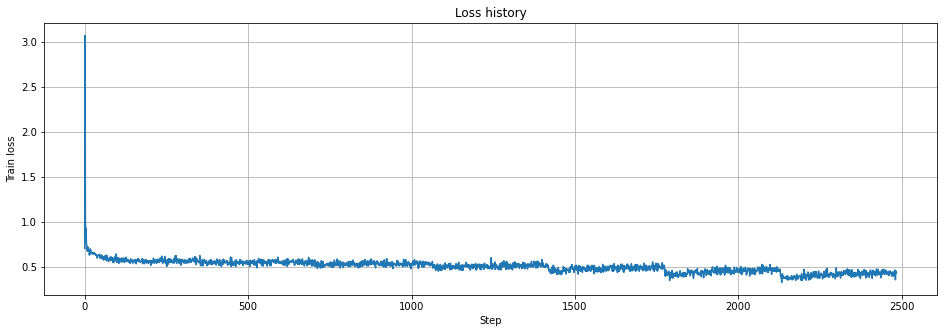

In [31]:
plt.figure(figsize = (16,5))
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);